# Machine Learning: Assignment 1

In [11]:
import numpy as np
import pandas as pd
import time
import gc
import random
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import validation_curve
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.model_selection import LearningCurve, ValidationCurve
from sklearn.preprocessing import OneHotEncoder

# 1. Data Import, leansing Setup and helper functions

In [12]:
class Data():
    def dataAllocation(self,path):
        # df = pd.read_csv(path)
        # x_data = df.iloc[:, :-1]
        # y_data = df.iloc[:, -1 ]
        # return x_data,y_data
        X, y = make_classification(n_samples=500, n_features=5, n_informative=5, n_redundant=0, random_state=rs)
        return X, y

    def trainSets(self,x_data,y_data):
        x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.3, random_state = rs, shuffle = True)
        return x_train, x_test, y_train, y_test

data = 'data/pima-indians-diabetes.csv'
rs = 614
dataset = Data()
x_data,y_data = dataset.dataAllocation(data)
x_train, x_test, y_train, y_test = dataset.trainSets(x_data,y_data)
scaler = StandardScaler()
scaled_x_train = scaler.fit_transform(x_train)
scaled_x_test = scaler.transform(x_test)
sizes = np.linspace(0.3, 1.0, 10)
# print("Heatmap for Features")
# data_corr = sns.heatmap(pd.DataFrame(x_train).corr(), cmap='Blues')

def fakeTunedData(i):
    fakeData = [{'max_depth': 9, 'min_samples_leaf': 1}, {'C': 0.01, 'kernel': 'linear'}, {'n_neighbors': 3}, {'hidden_layer_sizes': 81, 'learning_rate_init': 0.04},{'max_depth': 3, 'n_estimators': 90}]
    return 72+i, fakeData[i]

def learningCurvePlot(tuned):
    visualizer = LearningCurve(tuned, scoring='f1_weighted', train_sizes=sizes, n_jobs=4)
    visualizer.fit(x_data,y_data)
    visualizer.show()

# 2. Decision Tree Classifier

In [13]:
class DTClassifier():

    def trainTest(self):
        df = []
        for i in range(16):
            for j in range(20):
                dt_clf = DecisionTreeClassifier(max_depth=i+1, min_samples_leaf=j+1)
                dt_clf.fit(x_train, y_train)
                
                y_predict_train = dt_clf.predict(x_train)
                y_predict_test = dt_clf.predict(x_test)
                df.append([i+1, j+1, "Train", f1_score(y_train, y_predict_train)])
                df.append([i+1, j+1, "Test", f1_score(y_test, y_predict_test)])

        return pd.DataFrame(df, columns=["Depth", "Leaf Size", "Sample Type", "F1 Score" ])

    def hyperParameterTuning(self):
        param_grid = {'max_depth': range(1, 21), 'min_samples_leaf': range(1, 20)}
        tuned = GridSearchCV(estimator = DecisionTreeClassifier(random_state = rs), param_grid = param_grid, cv=10)
        tuned.fit(x_train, y_train)
        return tuned.best_score_, tuned.best_params_

    def dataExplorePlot(self, df):
        g = sns.FacetGrid(df, hue="Sample Type", col="Depth", height=2, col_wrap=4)
        g.map(sns.lineplot, "Leaf Size", "F1 Score" )
    
    def showLearningCurve(self, best_params):
        tuned = DecisionTreeClassifier(max_depth=best_params['max_depth'], min_samples_leaf=best_params['min_samples_leaf'], random_state=rs)
        learningCurvePlot(tuned)

# 3. Support Vector Machine

In [14]:
class SupportVectorMachine():
    def trainTest(self):
        cs = [x/10000 for x in [1, 10, 100, 1000, 10000, 100000, 1000000]]
        df = []
        for c in cs:
            for k in ["linear", "sigmoid"]:
                model = SVC(kernel = k, C=c)
                model.fit(scaled_x_train,y_train)
                y_predict_train = model.predict(scaled_x_train)
                y_predict_test = model.predict(scaled_x_test)
                df.append([k, c, accuracy_score(y_predict_test, y_test)])
        return pd.DataFrame(df, columns=["Kernel", "C", "Accuracy"])
    
    def hyperParameterTuning(self):
        param_grid = {'C': [x/10000 for x in [1, 10, 100, 1000, 10000, 100000, 1000000]],  
            'kernel': ["linear", "sigmoid"]}  
        svm_tune = SVC(gamma = "auto")
        svm_cv = GridSearchCV(estimator = svm_tune, param_grid = param_grid, n_jobs=5, return_train_score=True)
        svm_cv.fit(scaled_x_train, y_train)
        best_score = svm_cv.best_score_
        return best_score, svm_cv.best_params_
    
    def dataExplorePlot(self, df):
        g = sns.FacetGrid(df, col="Kernel",  height=4)
        g.map(sns.pointplot, "C", "Accuracy")
    
    def showLearningCurve(self, best_params):
        tuned = SVC(kernel=best_params['kernel'], C=best_params['C'])
        learningCurvePlot(tuned)
        

# 4. KNN

In [15]:
class KNN():
    def trainTest(self):
        df = []
        for i in range(20):
            model = KNeighborsClassifier(n_neighbors= i+1)
            model.fit(x_train, y_train)
            y_predict_test = model.predict(x_test)
            df.append([i+1, accuracy_score(y_predict_test, y_test)])
        return pd.DataFrame(df, columns= ["Neighbors", "Accuracy"])
    
    def hyperParameterTuning(self):
        tuned = GridSearchCV(KNeighborsClassifier(), {"n_neighbors" : range(1, 21)})
        tuned.fit(x_train, y_train)
        return tuned.best_score_, tuned.best_params_

    def dataExplorePlot(self, df):
        sns.lineplot(data=df, x="Neighbors", y="Accuracy")
    
    def showLearningCurve(self, best_params):
        tuned = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'])
        learningCurvePlot(tuned)


# 5. Neural Network

In [16]:
class NN():

    def trainTest(self):
        df = []
        for i in [0.01, 0.02, 0.04, 0.08, 0.1]:
            model = MLPClassifier(max_iter=300, learning_rate_init=i)
            model.fit(scaled_x_train,y_train)
            y_predict_train = model.predict(scaled_x_train)
            y_predict_test = model.predict(scaled_x_test)
            df.append([i, accuracy_score(y_predict_test, y_test)])
        return pd.DataFrame(df, columns=["Learning Rate", "Accuracy"])
        
    def hyperParameterTuning(self):
        param_grid = {
            'hidden_layer_sizes': [x**2 for x in range(2, 11)],
            'learning_rate_init': [0.01, 0.02, 0.04, 0.08, 0.1]
        }
        tuned = GridSearchCV(MLPClassifier(max_iter=50), param_grid = param_grid, cv=10)
        tuned.fit(scaled_x_train, y_train)
        return tuned.best_score_, tuned.best_params_

    def dataExplorePlot(self, df):
        sns.lineplot(data=df, x="Learning Rate", y="Accuracy")
    
    def showLearningCurve(self, best_params):
        tuned = MLPClassifier(max_iter=50, learning_rate_init=best_params['learning_rate_init'], hidden_layer_sizes=best_params['hidden_layer_sizes'])
        learningCurvePlot(tuned)

# 6. Boost

In [17]:
class Boost():
    def trainTest(self):
        df = []
        for i in range(50, 251, 10):
            model = GradientBoostingClassifier(n_estimators=i, max_depth=3, min_samples_leaf=10)
            model.fit(scaled_x_train,y_train)
            y_predict_train = model.predict(scaled_x_train)
            y_predict_test = model.predict(scaled_x_test)
            df.append([i, accuracy_score(y_predict_test, y_test)])
        return pd.DataFrame(df, columns=["Estimators", "Accuracy"])
        
    def hyperParameterTuning(self):
        param_grid = {'n_estimators': range(50, 151, 40), 'max_depth': range(2, 4)}
        tuned = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=10)
        tuned.fit(scaled_x_train, y_train)
        return tuned.best_score_, tuned.best_params_
    
    def dataExplorePlot(self, df):
        sns.lineplot(data=df, x="Estimators", y="Accuracy")

    def showLearningCurve(self, best_params):
        tuned = GradientBoostingClassifier(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], min_samples_leaf=100)
        learningCurvePlot(tuned)
    

1. Decision Tree

1.1 Hyperparameters Exploration

For this project, Decision Tree will be hypertuned by adjusting: ['max_depth', 'min_samples_leaf']. The following chart shows how the accuracy is affected when the hyperparamter(s) are changed:



1.2 Hypertuning

GridSearchCV was performed for Decision Tree classifier. The optimal value of max_depth was 9. The optimal value of min_samples_leaf was 1. Likewise the accuracy of Decision Tree classifier is 72 when the classifier uses the optimized hyperparameter(s) value(s).


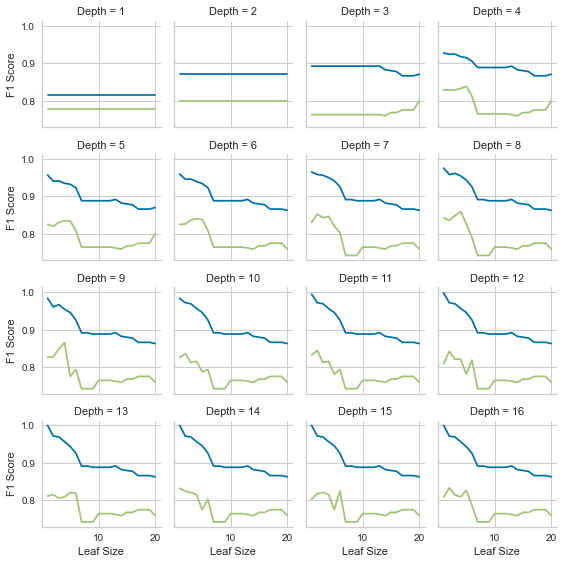

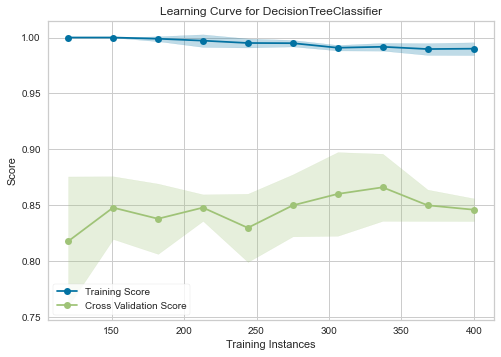



2. Support Vector Machine

2.1 Hyperparameters Exploration

For this project, Support Vector Machine will be hypertuned by adjusting: ['C', 'kernel']. The following chart shows how the accuracy is affected when the hyperparamter(s) are changed:



2.2 Hypertuning

GridSearchCV was performed for Support Vector Machine classifier. The optimal value of C was 0.01. The optimal value of kernel was linear. Likewise the accuracy of Support Vector Machine classifier is 73 when the classifier uses the optimized hyperparameter(s) value(s).


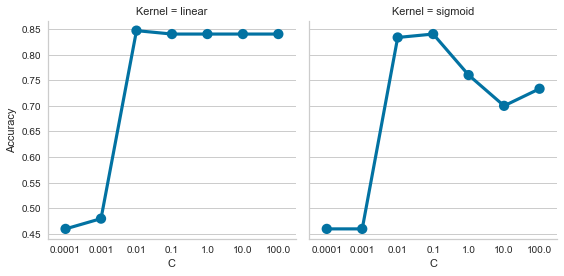

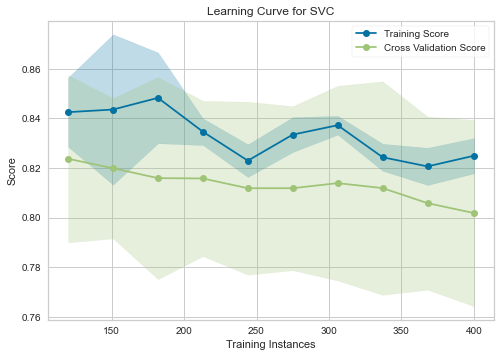



3. K-Nearest Neighbors

3.1 Hyperparameters Exploration

For this project, K-Nearest Neighbors will be hypertuned by adjusting: ['n_neighbors']. The following chart shows how the accuracy is affected when the hyperparamter(s) are changed:



3.2 Hypertuning

GridSearchCV was performed for K-Nearest Neighbors classifier. The optimal value of n_neighbors was 3. Likewise the accuracy of K-Nearest Neighbors classifier is 74 when the classifier uses the optimized hyperparameter(s) value(s).


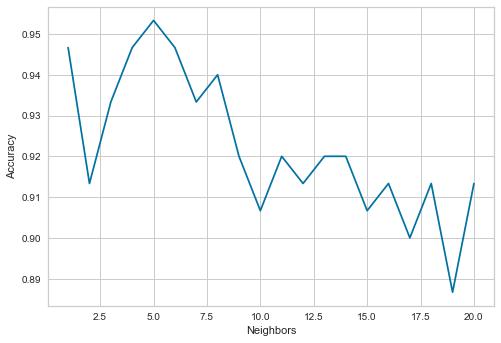

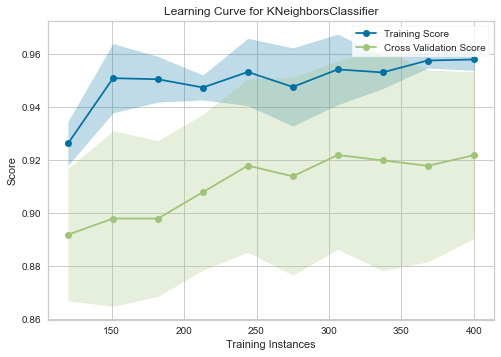



4. Neural Network

4.1 Hyperparameters Exploration

For this project, Neural Network will be hypertuned by adjusting: ['hidden_layer_sizes', 'learning_rate_init']. The following chart shows how the accuracy is affected when the hyperparamter(s) are changed:



4.2 Hypertuning

GridSearchCV was performed for Neural Network classifier. The optimal value of hidden_layer_sizes was 81. The optimal value of learning_rate_init was 0.04. Likewise the accuracy of Neural Network classifier is 75 when the classifier uses the optimized hyperparameter(s) value(s).


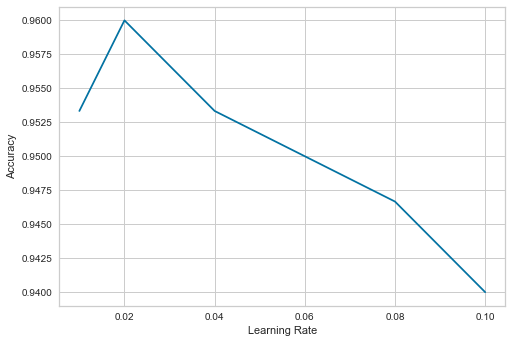

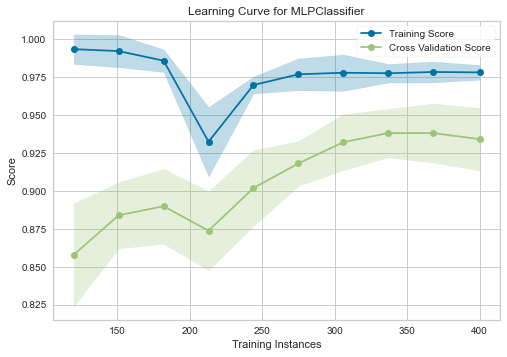



5. Gradient Boosting

5.1 Hyperparameters Exploration

For this project, Gradient Boosting will be hypertuned by adjusting: ['max_depth', 'n_estimators']. The following chart shows how the accuracy is affected when the hyperparamter(s) are changed:



5.2 Hypertuning

GridSearchCV was performed for Gradient Boosting classifier. The optimal value of max_depth was 3. The optimal value of n_estimators was 90. Likewise the accuracy of Gradient Boosting classifier is 76 when the classifier uses the optimized hyperparameter(s) value(s).


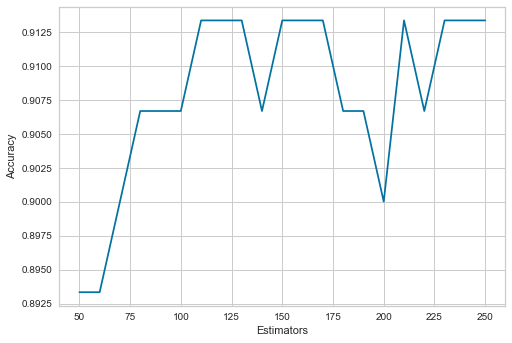

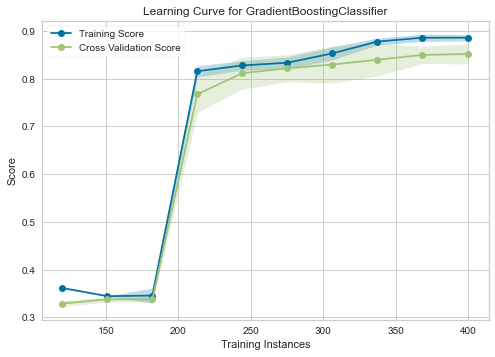

In [26]:
classifiers = [DTClassifier(), SupportVectorMachine(), KNN(), NN(), Boost()]
classifiers_name = ["Decision Tree", "Support Vector Machine", "K-Nearest Neighbors", "Neural Network", "Gradient Boosting"]

i = 0

for classifier in classifiers:
    name = classifiers_name[i]
    print(str(i+1)+".", name, end="\n\n")
    df = classifier.trainTest()
    best_score, best_params = fakeTunedData(i)
    print(str(i+1)+".1","Hyperparameters Exploration", end="\n\n")
    print("For this project,", name, "will be hypertuned by adjusting:", [x for x in best_params], end=". ")
    print("The following chart shows how the accuracy is affected when the hyperparamter(s) are changed:")

    classifier.dataExplorePlot(df)
    plt.figure()
    #best_score, best_params = classifier.hyperParameterTuning()
    #print(best_score, best_params)
    print("\n\n")
    print(str(i+1)+".2","Hypertuning", end="\n\n")
    print("GridSearchCV was performed for", name, "classifier" , end=". ")
    for key in best_params:
        print("The optimal value of", key, "was", best_params[key], end = ". ")
    print("Likewise the accuracy of", name, "classifier", "was", best_score, "when the optimized hyperparameter(s) value(s) were used.")
    classifier.showLearningCurve(best_params)
    print()
    print()

    i = i + 1
